# Mimicking Keras' predict   

The goal is that given a trained Keras model and an input event I can produce the same prediction as Keras.

In [12]:
#In this example I will use Keras to navigate the model, may need to do this manually if I fully port the code to C or C++

#System imports
from __future__ import print_function

#External imports 
from keras import layers, models
from keras import backend as K
from matplotlib import pyplot as plt

#Local imports 
from naive_prediction.data_utils import read_keras_model_from_file
from naive_prediction.forward_pass import predict_with_keras_model
from data import generate_straight_tracks
from drawing import draw_2d_event, draw_2d_input_and_pred
import naive_prediction.tests

#For consistent printing
import numpy as np
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


So I've trained an example model (the training is worthless, but it's a model created by Keras nonetheless). 

I'm going to load it into this notebook, have a look at it, and try to complete a forward pass using my modules.

In [13]:
#load model, summary
model = read_keras_model_from_file('/Users/Thomas/Desktop/opencl-cnn/model1.h5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 64, 64)        0                                            
____________________________________________________________________________________________________
reshape_5 (Reshape)              (None, 64, 64, 1)     0           input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 64, 8)     80          reshape_5[0][0]                  
____________________________________________________________________________________________________
convolution2d_28 (Convolution2D) (None, 64, 64, 8)     584         convolution2d_27[0][0]           
___________________________________________________________________________________________

This looks like what we'd expect. Now let us create an input example, predict using Keras, and see if we can reproduce the prediction with out own code.

In [14]:
# Batch generator function, from heptrkx
def batch_generator_convae(num_event, det_shape, num_tracks, binary=True):
    """
    Generator function for batches of toy data for training.
    This function generates a fixed number of tracks in a batch.
    """
    while True:
        events = sum(generate_straight_tracks(num_event, det_shape)
                     for i in range(num_tracks))
        if binary:
            events[events > 1] = 1
        # Input and target are the same here
        yield events, events

<IPython.core.display.Javascript object>


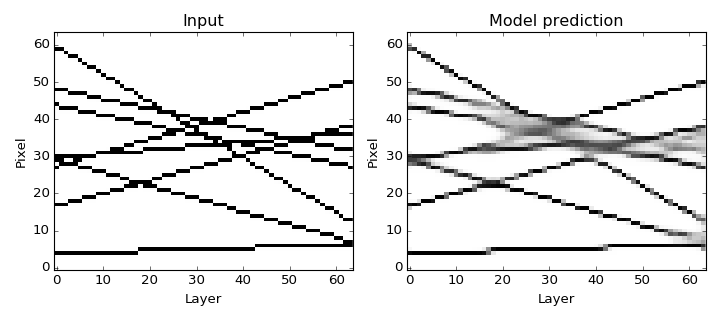

In [15]:
num_test = 1
det_shape = (64, 64)
num_tracks = 8
test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
test_pred = model.predict(test_events)
draw_2d_input_and_pred(test_events[0], test_pred[0], cmap='gray_r');

So we were able to make our prediction with Keras. Now let's try to do the same using our methods.

Let's make a prediction using our own methods:

In [16]:
our_prediction = predict_with_keras_model(model, test_events)

#### Comparing Keras' result to ours

In the plots first we have my result and then Keras':

test_events vs our prediction


<IPython.core.display.Javascript object>


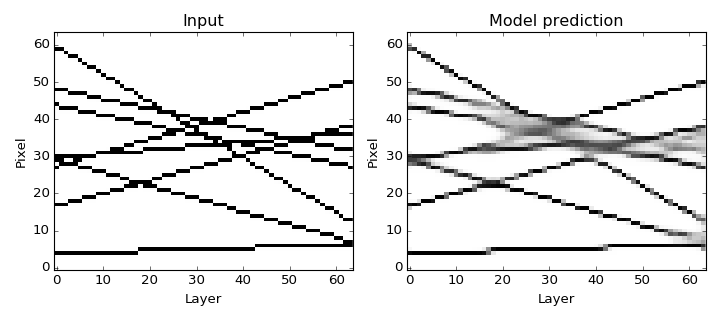

test_events vs keras prediction


<IPython.core.display.Javascript object>


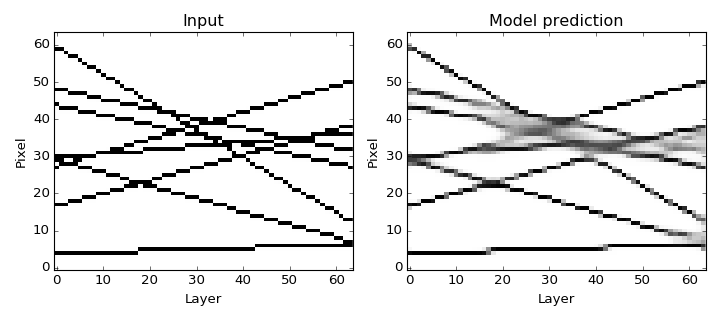

In [20]:
pred_output = np.reshape(our_prediction, (64, 64))
print("test_events vs our prediction")
draw_2d_input_and_pred(test_events[0], pred_output, cmap='gray_r');
print("test_events vs keras prediction")
draw_2d_input_and_pred(test_events[0], test_pred[0], cmap='gray_r');

It's very clear that our prediction is the exact same as Keras' visually. I've made a little testing script that tests each layer individually and compares Keras' output on that layer to mine.

For the most part you can see my script produces the same output as Keras, however values being within '0.00001' (arbitrary small number, could probably be smaller) may be a good metric for equality. I think operation precision causes some outputs not to be equal which makes my output different from Keras' after some convolution operations even though the outputs are all extremely close to eachother. 

Long story short, every layer produces the same output as Keras, which you can see below where every layer is compared to Keras. 

In [19]:
naive_prediction.tests.full_run_comparison(model, test_events)


Forward pass on a reshape_5 layer.
PASS: This layer successfully produces the same results as Keras.
Using self output as input 4096  of 4096  correctly predicted
Using keras output as input 4096  of 4096  correctly predicted
SUCCESS: All output values within 0.00001 of eachother.

Forward pass on a convolution2d_27 layer.
PASS: This layer successfully produces the same results as Keras.
Using self output as input 31739  of 32768  correctly predicted
Using keras output as input 32768  of 32768  correctly predicted
SUCCESS: All output values within 0.00001 of eachother.

Forward pass on a convolution2d_28 layer.
FAIL: This layer does no perform in the same way as Keras.
Using self output as input 27628  of 32768  correctly predicted
Using keras output as input 27569  of 32768  correctly predicted
SUCCESS: All output values within 0.00001 of eachother.

Forward pass on a maxpooling2d_7 layer.
PASS: This layer successfully produces the same results as Keras.
Using self output as input 62